### 현재 검증 손실(val_loss)이 이전 최소 검증 손실(early_stopping_loss)보다 작으면 모델의 상태를 저장

early_stopping_loss = 1  

if val_loss < early_stopping_loss:  
    torch.save(resnet.state_dict(), PATH)  
    early_stopping_train_loss = train_loss  
    early_stopping_val_loss = val_loss  
    early_stopping_epoch = epoch  

> [18] train loss: 0.045 , validation loss: 0.972  
> [19] train loss: 0.036 , validation loss: 1.067

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [30000, 20000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) 
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)

        out = F.relu(x + out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4) # 4: 필터 사이즈
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
    
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])

    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])


In [6]:
ResNet([2, 2, 2, 2])

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [7]:
ResNet([3, 4, 6, 3])

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [8]:
resnet = modeltype('resnet18').to(device)

In [9]:
PATH = './models/cifar_resnet_early.pth'

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [11]:
def validation_loss(dataloader):
    n = len(dataloader)
    running_loss = 0.0
    with torch.no_grad():
        resnet.eval()
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    resnet.train()
    return running_loss / n

In [12]:
train_loss_list = [] # 그래프를 그리기 위한 loss 저장용 리스트 
val_loss_list = []
n = len(trainloader) # 배치 개수
early_stopping_loss = 1
for epoch in range(51): 

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()
        outputs = resnet(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    train_loss = running_loss / n
    train_loss_list.append(train_loss)    
    val_loss = validation_loss(valloader)
    val_loss_list.append(val_loss)
    
    print('[%d] train loss: %.3f , validation loss: %.3f' %(epoch + 1, train_loss, val_loss))
    
# 현재 검증 손실(val_loss)이 이전 최소 검증 손실(early_stopping_loss)보다 작으면 모델의 상태를 저장
    if val_loss < early_stopping_loss:
        torch.save(resnet.state_dict(), PATH)
        early_stopping_train_loss = train_loss
        early_stopping_val_loss = val_loss
        early_stopping_epoch = epoch
        
print('Final pretrained model >> [%d] train loss: %.3f , validation loss: %.3f' %(early_stopping_epoch + 1, 
                                                        early_stopping_train_loss, early_stopping_val_loss))

[1] train loss: 1.516 , validation loss: 1.417
[2] train loss: 1.035 , validation loss: 0.917
[3] train loss: 0.782 , validation loss: 0.734
[4] train loss: 0.620 , validation loss: 0.653
[5] train loss: 0.491 , validation loss: 0.707
[6] train loss: 0.382 , validation loss: 0.628
[7] train loss: 0.278 , validation loss: 0.704
[8] train loss: 0.195 , validation loss: 0.643
[9] train loss: 0.141 , validation loss: 0.750
[10] train loss: 0.112 , validation loss: 0.783
[11] train loss: 0.093 , validation loss: 0.870
[12] train loss: 0.078 , validation loss: 0.928
[13] train loss: 0.062 , validation loss: 0.873
[14] train loss: 0.070 , validation loss: 0.881
[15] train loss: 0.060 , validation loss: 0.929
[16] train loss: 0.045 , validation loss: 0.936
[17] train loss: 0.052 , validation loss: 0.909
[18] train loss: 0.045 , validation loss: 0.972
[19] train loss: 0.036 , validation loss: 1.067
[20] train loss: 0.040 , validation loss: 0.954
[21] train loss: 0.035 , validation loss: 1.042
[

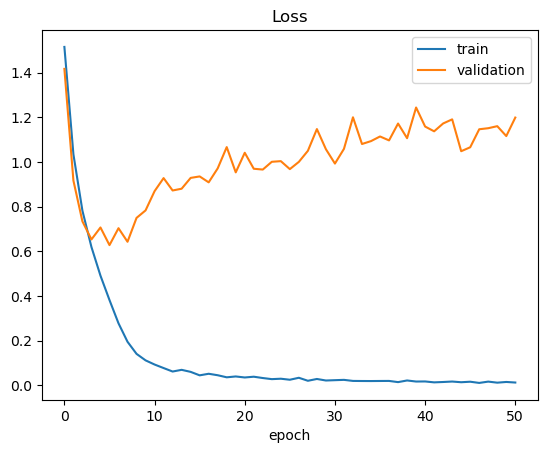

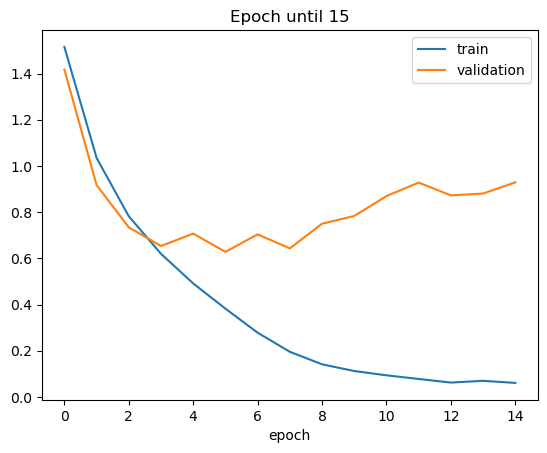

In [14]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()


plt.figure()

plt.plot(train_loss_list[:15])
plt.plot(val_loss_list[:15])
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.title("Epoch until 15")
plt.show()

In [15]:
resnet = modeltype('resnet18').to(device)
resnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Test accuracy: %.2f %%' % (100 * correct / total))

Test accuracy: 81.98 %
